In [1]:
#!git clone https://github.com/axelcarlier/animals.git
!git clone https://github.com/echigot/deep-learning-3A.git

Cloning into 'deep-learning-3A'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
IMAGE_SIZE = 64 # Dimension des images en entrée du réseau
CELL_PER_DIM = 8 # Nombre de cellules en largeur et en hauteur
NB_CLASSES = 10 # Nombre de classes du problème
PIX_PER_CELL = IMAGE_SIZE/CELL_PER_DIM
#DATASET_SIZE = 1200
DATASET_SIZE = 369
BOX_PER_CELL = 1 # Code à modifier pour avoir plusieurs animaux par cellule ?

In [ ]:
import PIL
from PIL import Image
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import math
%matplotlib inline

import keras
from keras.utils import np_utils

# Chemin vers la base de données
#path = "./animals/unlabelled/"
path = "./deep-learning-3A/animals-master/labelled/"
# Indice d'ajout de données dans les variables x et y 
i = 0
# Préparation des structures de données pour x et y
#x = np.zeros((50000, 64, 64, 3))
x = np.zeros((DATASET_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
y = np.zeros((DATASET_SIZE, CELL_PER_DIM, CELL_PER_DIM, NB_CLASSES + 5*BOX_PER_CELL))

# Sauvegarde des largeur/hauteur normalisées de bounding box
widths = []
heights = []

# Parcours des fichiers (classés) du répertoire
dirs = os.listdir(path)
dirs.sort()

for item in dirs:
  # On sépare image et texte avec l'extension
  extension = item.split(".")[1]

  #if extension=="jpg":
    #img = Image.open(path + item)
    #x[i] = np.asarray(img)

  if extension=="txt":
    # Texte : coordonnées de boîtes englobantes pour remplir y
    labels = open(path + item, "r")
    # Récupération des lignes du fichier texte
    labels = labels.read().split('\n')
    # Si la dernière ligne est vide, la supprimer 
    if labels[-1]=="":
      del labels[-1]

    boxes = []
    for label in labels:
      # Récupération des informations de la boîte englobante
      label = label.split()
      # Sauvegarde des largeur/hauteur de boîtes englobantes
      widths.append(float(label[3]))
      heights.append(float(label[4]))
      # Coordonnées du centre de la boîte englobante dans le repère image
      cx, cy = float(label[1]) * IMAGE_SIZE, float(label[2]) * IMAGE_SIZE
      # Détermination des indices de la cellule dans laquelle tombe le centre
      ind_x, ind_y = int(cx // PIX_PER_CELL), int(cy // PIX_PER_CELL)
      # YOLO : "The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell."
      # On va donc calculer les coordonnées du centre relativement à la cellule dans laquelle il se situe
      cx_cell = (cx - ind_x * PIX_PER_CELL) / PIX_PER_CELL
      cy_cell = (cy - ind_y * PIX_PER_CELL) / PIX_PER_CELL
      # Indice de confiance de la boîte englobante
      presence = np.array([1], dtype="i")
      # "One-hot vector" représentant les probabilités de classe dans la cellule
      classes = np_utils.to_categorical(label[0], num_classes=10)
      # On range les probabilités de classe à la fin du vecteur ([ BOX 1 ; BOX 2 ; ... ; BOX N ; CLASSES])
      y[i, ind_x, ind_y, 5 * BOX_PER_CELL:] = classes

      boxes.append([cx, cy, label[3]*IMAGE_SIZE, label[4]*IMAGE_SIZE])
      # Détermination de l'indice de la boîte englobante de cellule dans laquelle ranger les informations
      ind_box = 0
      while y[i, ind_x, ind_y, 5*ind_box] == 1 and ind_box < BOX_PER_CELL - 1:
        # Si la boîte d'indice courant est déjà utilisée (présence = 1) 
        # et que l'on a pas atteint le nombre maximal de boîtes, on passe à la boîte suivante
        ind_box = ind_box + 1

      if y[i, ind_x, ind_y, 5*ind_box] == 1:
        print("ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES")
        print(path + item)
      else:
        y[i, ind_x, ind_y, 5*ind_box] = 1
        y[i, ind_x, ind_y, 5*ind_box + 1] = cx_cell
        y[i, ind_x, ind_y, 5*ind_box + 2] = cy_cell
        # Racine carrée de la largeur et hauteur de boîte
        y[i, ind_x, ind_y, 5*ind_box + 3] = math.sqrt(float(label[3]))
        y[i, ind_x, ind_y, 5*ind_box + 4] = math.sqrt(float(label[4]))

    i = i+1

In [ ]:
i = 0
for item in dirs:
  # Image : on va remplir la variable x
  # Lecture de l'image
  extension = item.split(".")[1]
  if extension=="jpg":
    img = Image.open(path + item)
    # Remplissage de la variable x
    x[i] = np.asarray(img)
    i = i+1

x = x.astype('uint8')

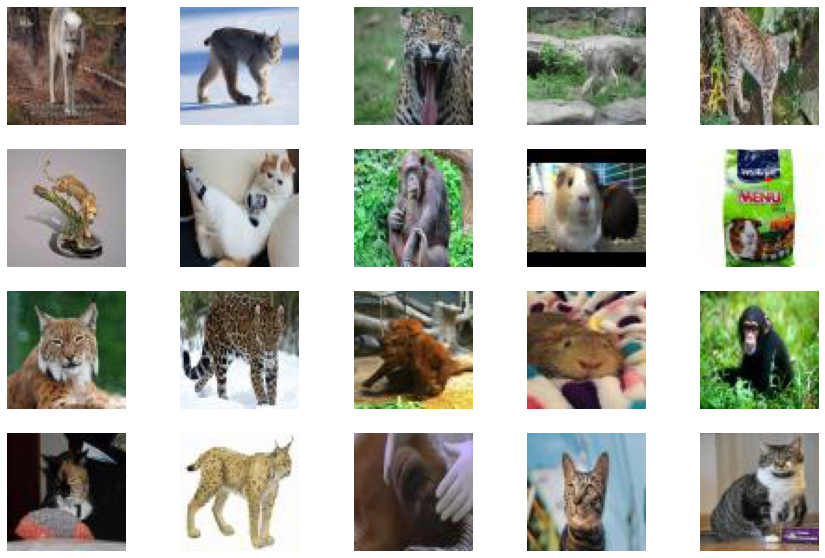

In [ ]:
# Visualiser la base de données
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(15, 10))

for i in range(20):
  num = np.random.randint(x.shape[0])
  plt.subplot(4, 5, i+1)
  plt.imshow(x[num]);
  plt.axis('off')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Normalisation des images
x_train = x_train/255
x_val = x_val/255

173


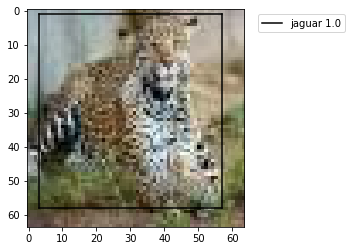

In [ ]:
from scipy.special import softmax

def print_data_detection(x, y, id=None, image_size=IMAGE_SIZE, mode='gt'):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0])
    print(num_img)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "yellow", "red", "orange", "green", "purple", "white", "black","gray","pink"]
  classes = ["hamster","cochon d'inde","loup","coyote","chat","lynx","guépard","jaguar","orang-outan","chimpanzé"]

  boxes = lab[:, :, 1:5]
  for ind_x in range(CELL_PER_DIM):
    for ind_y in range(CELL_PER_DIM):
      box = boxes[ind_x, ind_y]
      box[0] = box[0] * PIX_PER_CELL + ind_x * PIX_PER_CELL
      box[1] = box[1] * PIX_PER_CELL + ind_y * PIX_PER_CELL
      box[2] = box[2]**2 * IMAGE_SIZE
      box[3] = box[3]**2 * IMAGE_SIZE
      boxes[ind_x, ind_y] = box

  # Récupération de toutes les informations des boîtes englobantes
  all_presences = np.reshape(lab[:, :, 0], (CELL_PER_DIM*CELL_PER_DIM))
  all_boxes = np.reshape(lab[:, :, 1:5], (-1, 4))
  all_classes = np.reshape(lab[:, :, 5:14], (-1, 9))

  if mode=='pred':
    all_presences = 1 / (1 + np.exp(-all_presences))
    all_classes = softmax(all_classes, axis=1)

  indices_sorted = np.argsort(-all_presences)
  #print(all_presences[indices_sorted[0:5]])
  #print(all_classes[indices_sorted[0:5]])

  # Eliminer toutes les boîtes englobantes dont la probabilité de presence est < 0.5 
  seuil = 0.35
  all_boxes = all_boxes[np.where(all_presences > seuil)]
  all_classes = all_classes[np.where(all_presences > seuil)]
  all_presences = all_presences[np.where(all_presences > seuil)]


  # Affichage de l'image
  plt.imshow(img)
  for i in range(all_boxes.shape[0]):

    # Détermination de la classe
    class_id = np.argmax(all_classes[i])
    lab = all_boxes[i]
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [lab[0]-lab[2]/2, lab[0]+lab[2]/2]
    p_y = [lab[1]-lab[3]/2, lab[1]+lab[3]/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id], label=classes[class_id] + " " +  str(all_presences[i]))
    #plt.title("Vérité Terrain : Image {}".format(num_img, classes[class_id]))
  
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()  


print_data_detection(x_train, y_train, image_size=IMAGE_SIZE)

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((313, 64, 64, 3), (313, 8, 8, 15), (56, 64, 64, 3), (56, 8, 8, 15))